# Spam Classification

This is a simple SMS spam classification model. Here this dataset is obtained from kaggle.

Data Source Link: https://www.kaggle.com/uciml/sms-spam-collection-dataset

Here in this dataset, I am going to perform a simple Bag of words technique for spam classification. Please Note this model may not be a very robust model, since this technique depends on the text on the data,so this might not give accurate results on recent real life spam/ham messages.

We will be using TfidfVectorizer for this project, since applies a lower weightage to those words which occurs multiple times in all text messages. TfidfVectorizer generally is a better choice CountVectorizer in this regard.

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import seaborn as sns
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import span
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.preprocessing import StandardScaler

nlp=spacy.load('en_core_web_sm')


### Collecting data into pandas

In [3]:
df=pd.read_csv("spam.csv", encoding = 'latin-1')

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Changing the names of columns for simplicity

In [10]:
df.columns=['Type','Text']
df.head()

,Type,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Checking for null values

In [20]:
df.isnull().sum()    # This gives number of Null values

v1    0
v2    0
dtype: int64

### Checking the class imbalance

In [12]:
df['Type'].value_counts()

ham     4825
spam     747
Name: Type, dtype: int64

### Balancing class imbalance using RandomUndersampling

In [13]:
ham=df[df['Type']=='ham']
ham.head()

,Type,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...


In [14]:
spam=df[df['Type']=='spam']
spam.head()

,Type,Text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


### Randomly selecting 747 sets from Ham

In [15]:
ham=ham.sample(747)

In [16]:
ham.shape, spam.shape

((747, 2), (747, 2))

In [17]:
data=ham.append(spam,ignore_index=True)

In [18]:
data.head()

,Type,Text
0,ham,"Okey dokey, iÛ÷ll be over in a bit just sorti..."
1,ham,K.. I yan jiu liao... Sat we can go 4 bugis vi...
2,ham,\YEH I AM DEF UP4 SOMETHING SAT
3,ham,You have registered Sinco as Payee. Log in at ...
4,ham,What happen dear. Why you silent. I am tensed


In [19]:
data.tail()

,Type,Text
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...
1493,spam,This is the 2nd time we have tried 2 contact u...


### Creating few features

In [65]:
data['wordcount']=data['Text'].apply(lambda x: len(str(x).split()))
data.sample(5)

,Type,Text,wordcount
737,ham,I have no money 4 steve mate! !,8
476,ham,I'm fine. Hope you are good. Do take care.,9
1165,spam,LORD OF THE RINGS:RETURN OF THE KING in store ...,27
1458,spam,"If you don't, your prize will go to another cu...",27
835,spam,XCLUSIVE@CLUBSAISAI 2MOROW 28/5 SOIREE SPECIAL...,17


In [70]:
def char_count(x):
    s=x.split()
    x=''.join(s)
    return len(x)
data['charcount']=data['Text'].apply(lambda x : char_count(str(x)))
data['avewordlength']=data['charcount']/data['wordcount']
data.sample(5)

,Type,Text,wordcount,charcount,avewordlength
1275,spam,Great NEW Offer - DOUBLE Mins & DOUBLE Txt on ...,29,132,4.551724
559,ham,Ard 515 like dat. Y?,5,16,3.200000
620,ham,Yes. Last practice,3,16,5.333333
270,ham,Yes ammae....life takes lot of turns you can o...,16,70,4.375000
1420,spam,CDs 4u: Congratulations ur awarded å£500 of CD...,26,143,5.500000


In [72]:
# Remove Accented Chars
def remove_accented_chars(x):
    x=unicodedata.normalize('NFKD',x).encode('ascii','ignore').decode('utf-8','ignore')
    return x
data['Text']=data['Text'].apply(lambda x: remove_accented_chars(x))
data.sample(5)

,Type,Text,wordcount,charcount,avewordlength
134,ham,What's up. Do you want me to come online?,9,33,3.666667
927,spam,You have 1 new voicemail. Please call 08719181503,8,42,5.250000
723,ham,Hi good mornin.. Thanku wish u d same..,8,32,4.000000
609,ham,Why are u up so early?,6,17,2.833333
1146,spam,Sorry! U can not unsubscribe yet. THE MOB offe...,28,121,4.321429


In [90]:
# Finding if there are any numbers found
def phone_number(text):
    t=[]
    t=re.findall(r'\d{6,15}',text)
    if len(t)>0:
        return len(t)
    else:
        return 0
data['phone']=data['Text'].apply(lambda x: phone_number(x))
data.sample(5)

,Type,Text,wordcount,charcount,avewordlength,phone,email
894,spam,How about getting in touch with folks waiting ...,24,109,4.541667,0,0
1118,spam,Great NEW Offer - DOUBLE Mins & DOUBLE Txt on ...,29,132,4.551724,1,0
333,ham,R I_ going 4 today's meeting?,6,24,4.000000,0,0
746,ham,No got new job at bar in airport on satsgettin...,20,75,3.750000,0,0
1381,spam,FREE GAME. Get Rayman Golf 4 FREE from the O2 ...,29,125,4.310345,0,0


In [91]:
# Finding email
def email(text):
    t=[]
    t=re.findall(r'[\w]+@[\w]+',text)
    return len(t)
data['email']=data['Text'].apply(lambda x: email(x))
data.sample(5)

,Type,Text,wordcount,charcount,avewordlength,phone,email
181,ham,"I got like $ &lt;#&gt; , I can get some more l...",18,68,3.777778,0,0
1149,spam,"URGENT! Your mobile was awarded a a1,500 Bonus...",20,101,5.050000,1,0
552,ham,U wake up already? Thanx 4 e tau sar piah it's...,13,46,3.538462,0,0
608,ham,"Doing nothing, then u not having dinner w us?",9,37,4.111111,0,0
385,ham,No objection. My bf not coming.,6,26,4.333333,0,0


In [93]:
# Making everything to lower case
data['Text']=data['Text'].apply(lambda x:str(x).lower())

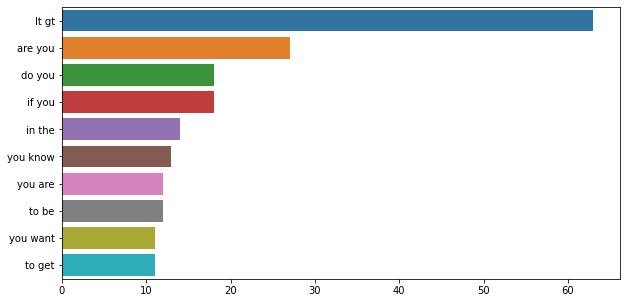

In [99]:
#bigram analysis for ham messages

def bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
bigrams1=bigrams(data[data['Type']=='ham']['Text'])[:10]
x,y=map(list,zip(*bigrams1))
sns.barplot(x=y,y=x)

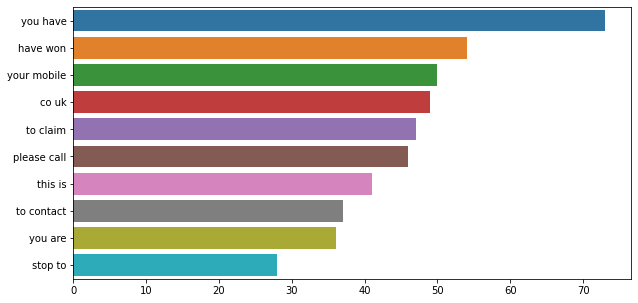

In [100]:
#bigram analysis for spam messages

plt.figure(figsize=(10,5))
bigrams1=bigrams(data[data['Type']=='spam']['Text'])[:10]
x,y=map(list,zip(*bigrams1))
sns.barplot(x=y,y=x)

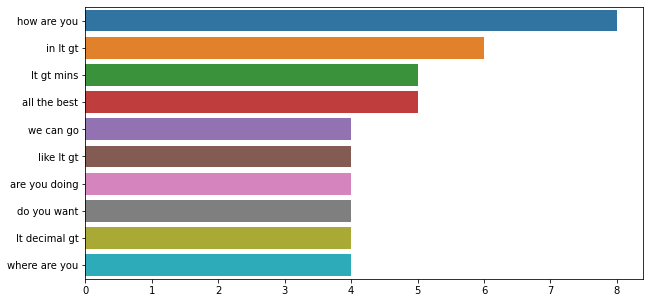

In [102]:
#trigram analysis for ham messages

def trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
grams1=trigrams(data[data['Type']=='ham']['Text'])[:10]
x,y=map(list,zip(*grams1))
sns.barplot(x=y,y=x)

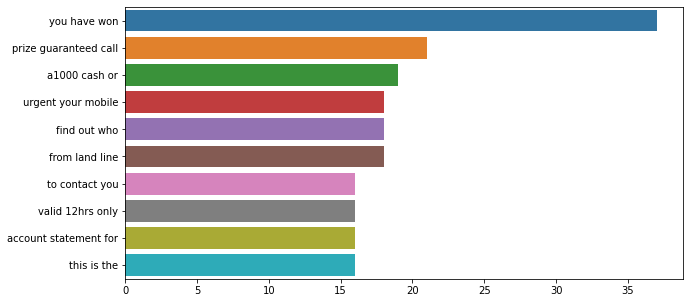

In [103]:
#trigram analysis for spam messages

plt.figure(figsize=(10,5))
grams1=trigrams(data[data['Type']=='spam']['Text'])[:10]
x,y=map(list,zip(*grams1))
sns.barplot(x=y,y=x)

In [134]:
def ham_grams(text):
    
    doc=nlp(text)
    
    pattern1=[{"LOWER":"how",'OP':'?'},{"LOWER":"are"},{"LOWER":"you"}]
    matcher1=Matcher(nlp.vocab)
    matcher1.add("Example", None, pattern1)
    matches1=matcher1(doc)
    
    pattern2=[{"LOWER":"it"},{"LOWER":"gt"}]
    matcher2=Matcher(nlp.vocab)
    matcher2.add("Example", None, pattern2)
    matches2=matcher(doc)
    
    pattern3=[{"LOWER":"do"},{"LOWER":"you"}]
    matcher3=Matcher(nlp.vocab)
    matcher3.add("Example", None, pattern3)
    matches3=matcher(doc)
    
    pattern4=[{"LOWER":"if"},{"LOWER":"you"}]
    matcher4=Matcher(nlp.vocab)
    matcher4.add("Example", None, pattern4)
    matches4=matcher(doc)
    
    pattern5=[{"LOWER":"you"},{"LOWER":"know"}]
    matcher5=Matcher(nlp.vocab)
    matcher5.add("Example", None, pattern5)
    matches5=matcher(doc)
    
    return len(matches1)+len(matches2)+len(matches3)+len(matches4)+len(matches5)

data['hamgrams']=data['Text'].apply(lambda x: ham_grams(x))
data.sample(5)

,Type,Text,wordcount,charcount,avewordlength,phone,email,spamgrams,hamgrams
32,ham,ambrith..madurai..met u in arun dha marrge..re...,6,47,7.833333,0,0,0,0
1468,spam,important message. this is a final contact att...,23,134,5.826087,1,0,1,0
299,ham,"some friends want me to drive em someplace, pr...",12,54,4.500000,0,0,0,0
1027,spam,themob>yo yo yo-here comes a new selection of ...,28,116,4.142857,0,0,0,0
547,ham,aathi..where are you dear..,4,24,6.000000,0,0,0,1


In [133]:
def spam_grams(text):
    
    doc=nlp(text)
    
    pattern1=[{"LOWER":"you"},{"LOWER":"have"},{"LOWER":"won",'OP':'?'}]
    matcher1=Matcher(nlp.vocab)
    matcher1.add("Example", None, pattern1)
    matches1=matcher1(doc)
    
    pattern2=[{"LOWER":"your"},{"LOWER":"mobile"}]
    matcher2=Matcher(nlp.vocab)
    matcher2.add("Example", None, pattern2)
    matches2=matcher(doc)
    
    pattern3=[{"LOWER":"to"},{"LOWER":"claim"}]
    matcher3=Matcher(nlp.vocab)
    matcher3.add("Example", None, pattern3)
    matches3=matcher(doc)
    
    pattern4=[{"LOWER":"please"},{"LOWER":"call"}]
    matcher4=Matcher(nlp.vocab)
    matcher4.add("Example", None, pattern4)
    matches4=matcher(doc)
    
    pattern5=[{"LOWER":"sex"}]
    matcher5=Matcher(nlp.vocab)
    matcher5.add("Example", None, pattern5)
    matches5=matcher(doc)
    
    return len(matches1)+len(matches2)+len(matches3)+len(matches4)+len(matches5)

data['spamgrams']=data['Text'].apply(lambda x: spam_grams(x))
data.sample(5)

,Type,Text,wordcount,charcount,avewordlength,phone,email,spamgrams,hamgrams
483,ham,1apple/day=no doctor. 1tulsi leaf/day=no cance...,21,134,6.380952,0,0,0,0
479,ham,lol! nah wasn't too bad thanks. its good to b ...,28,109,3.892857,0,0,0,0
1179,spam,urgent! we are trying to contact u. todays dra...,28,132,4.714286,1,0,2,0
690,ham,that's significant but dont worry.,5,30,6.000000,0,0,0,0
109,ham,i'm home. doc gave me pain meds says everythin...,11,46,4.181818,0,0,0,0


### Data preparation

In [223]:
X=data.drop(['Type'],1)
y=data['Type']

In [224]:
num_cols=['wordcount','charcount','avewordlength','phone','email','spamgrams','hamgrams']
transformer=make_column_transformer((StandardScaler(),num_cols),(TfidfVectorizer(),'Text'),remainder='passthrough')

In [228]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0,shuffle=True,stratify=y)

### Bag of words

In [229]:
vectorizer=TfidfVectorizer()

In [230]:
X_trainvec=vectorizer.fit_transform(X_train['Text'])

In [231]:
X_trainvec

<1045x3750 sparse matrix of type '<class 'numpy.float64'>'
	with 17869 stored elements in Compressed Sparse Row format>

### Model

I Have used Linear models like Logistic Regression in this project as it was giving better f1 scores. 
Since the input data is very sparse, it was expected that linear models will perform better in such cases.

In [232]:
clf=Pipeline([('transformer',transformer),('clf',LogisticRegression())])

In [233]:
clf.fit(X_train,y_train)

/home/suryanarayanan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['wordcount', 'charcount',
                                                   'avewordlength', 'phone',
                                                   'email', 'spamgrams',
                                                   'hamgrams']),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(ana...
               

In [234]:
y_pred=clf.predict(X_test)

In [235]:
confusion_matrix(y_test,y_pred)

array([[218,   7],
       [ 16, 208]])

In [236]:
accuracy_score(y_test,y_pred)

0.9487750556792873

In [237]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.93      0.97      0.95       225
        spam       0.97      0.93      0.95       224

    accuracy                           0.95       449
   macro avg       0.95      0.95      0.95       449
weighted avg       0.95      0.95      0.95       449



### Testing on some common examples

In [250]:
def predictions(text):
    df=pd.DataFrame([text],columns=['Text'])
    df['wordcount']=df['Text'].apply(lambda x: len(str(x).split()))
    df['charcount']=df['Text'].apply(lambda x : char_count(str(x)))
    df['avewordlength']=df['charcount']/df['wordcount']
    df['Text']=df['Text'].apply(lambda x: remove_accented_chars(x))
    df['phone']=df['Text'].apply(lambda x: phone_number(x))
    df['email']=df['Text'].apply(lambda x: email(x))
    df['Text']=df['Text'].apply(lambda x:str(x).lower())
    df['hamgrams']=df['Text'].apply(lambda x: ham_grams(x))
    df['spamgrams']=df['Text'].apply(lambda x: spam_grams(x))
    return df

In [249]:
X_t=predictions("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. call 98888888855")
clf.predict(X_t)

array(['spam'], dtype=object)

In [61]:
clf.predict(['Congratulations, you have won the free tickets to USA.Text WON" to 54554'])

array(['spam'], dtype=object)

In [247]:
X_t=predictions('Hi man, I was wondering if we can meet tomorrow.')
clf.predict(X_t)

array(['ham'], dtype=object)